In [1]:
seed = 0

In [2]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *
from utilities import model_utils

In [3]:
from time import time
import joblib
import os
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier, Booster, DMatrix

# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # RF
    models.append(RandomForestClassifier())
    names.append('RF')
    # XGB
    models.append(XGBClassifier(use_label_encoder=False))
    names.append('XGB')
    return models, names

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [5]:
def log_metrics_and_explanations(clf, X_val, y_true_val, y_pred_val, y_prob_val):
    cf = confusion_matrix(y_true_val, y_pred_val)
    f1 = f1_score(y_true_val, y_pred_val)
    X_trans = pd.DataFrame(clf.named_steps['nr'].transform(X_val), columns=X_val.columns)
    if type(clf.named_steps['m']).__name__ == 'RandomForestClassifier':
        explainer = shap.TreeExplainer(clf.named_steps['m'], X_trans)
        shap_test = explainer(X_trans, check_additivity=False)[:,:,1]
        shap_df = pd.DataFrame(shap_test.values, 
                               columns=shap_test.feature_names, 
                               index=X_val.index)
    else:
        explainer = shap.Explainer(clf.named_steps['m'], X_trans)
        shap_test = explainer(X_trans)    
        shap_df = pd.DataFrame(shap_test.values,
                               columns=shap_test.feature_names, 
                               index=X_val.index)
    ### Save to file
    timestring = "".join(str(time()).split("."))
    model_name = type(clf.named_steps['m']).__name__ + '.pkl'
    
    if not os.path.exists('results/Basic/models'):
        os.makedirs('results/Basic/models')
    model_savepath = 'results/Basic/models/{}'.format(model_name)

    model_utils.save_model(model_savepath, 
                           clf.get_params(), 
                           shap_test, 
                           shap_df, 
                           X_val, 
                           y_pred_val, 
                           y_prob_val, 
                           cf, 
                           f1)
    
    return f1

def _my_scorer(clf, X_val, y_true_val):
    # do all the work and return some of the metrics
    y_pred_val = clf.predict(X_val)
    y_prob_val = clf.predict_proba(X_val)
    f1 = log_metrics_and_explanations(clf, X_val, y_true_val, y_pred_val, y_prob_val)
    
    return f1

In [6]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = models[i]
    norm = Normalizer()
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('m',model)])
    # evaluate the model and store results
    print(model)
    scores = evaluate_model(X_train, y_train, pipeline, make_scorer(f1_score))
    results.append(scores)
results = np.array(results).T
results = pd.DataFrame(results, columns=names)
sorted_index = results.mean().sort_values().index
results = results[sorted_index]

LogisticRegression(solver='liblinear')
min: 0.056338028169014086
max: 0.1423728813559322
mean: 0.08957240792945279
LinearDiscriminantAnalysis()
min: 0.18713450292397657
max: 0.276657060518732
mean: 0.24270120440497214
RandomForestClassifier()
min: 0.3935309973045822
max: 0.4934383202099737
mean: 0.4497922646077861
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              v

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas

min: 0.40740740740740744
max: 0.4964200477326969
mean: 0.4568861689868321


In [7]:
for i in range(len(models)):
    model = models[i]
    norm = Normalizer()
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('m',model)])
    pipeline.fit(X_train, y_train)
    _my_scorer(pipeline, X_test, y_test)

100%|===================| 6017/6018 [02:33<00:00]        

[18:18:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [16]:
results

,LR,LDA,XGB,RF,GIU
0,0.117647,0.230548,0.432432,0.413043,0.418891
1,0.095563,0.263736,0.431078,0.439678,0.468750
2,0.056738,0.241888,0.451282,0.442049,0.485660
3,0.104530,0.263930,0.487562,0.454780,0.545455
4,0.077465,0.239521,0.395722,0.464000,0.527163
5,0.083045,0.220930,0.421053,0.448454,0.518664
6,0.070922,0.208333,0.493703,0.507538,0.487329
7,0.082474,0.249258,0.470000,0.443850,0.455939
8,0.093190,0.316076,0.397933,0.430108,0.483810
9,0.117647,0.217647,0.435407,0.460705,0.455487


In [23]:
import joblib
# Giudici
results['GIU'] = joblib.load('./results/giudici_scores.pkl')

# Opti
grid = joblib.load('./results/XGBoost/GridSearchCV_22-03-22_03-27-03/GridSearchCV_22-03-22_03-27-03.pkl')
grid_df = pd.DataFrame(grid.cv_results_)
filter_col = [col for col in grid_df if col.startswith('split')]
results['XGBB'] = grid_df[grid_df.mean_test_score == grid_df.mean_test_score.max()][filter_col].values.reshape((15,))

[13:44:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


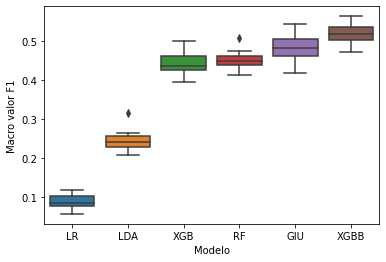

In [24]:
sns.boxplot(x="variable", y="value", data=pd.melt(results))
if not os.path.exists('figures/modeling_basic'):
    os.makedirs('figures/modeling_basic')
plt.ylabel('Macro valor F1')
plt.xlabel('Modelo')
plt.savefig('figures/modeling_basic/mb_F1_CV.png', bbox_inches='tight', dpi=300, transparent=True)

In [9]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import InstanceHardnessThreshold

In [10]:
def get_models():
    models, names = list(), list()
    # TL
    models.append(TomekLinks())
    names.append('TL')
    # ENN
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    # RENN
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    # NCR
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    # IHT
    models.append(InstanceHardnessThreshold())
    names.append('IHT')
    return models, names

In [ ]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = XGBClassifier(use_label_encoder=False)
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('s', models[i]), ('m',model)])
    # evaluate the model and store results
    print(models[i])
    scores = evaluate_model(X_train, y_train, pipeline, f1_macro)
    results.append(scores)
results = np.array(results).T
results = pd.DataFrame(results, columns=names)
sorted_index = results.mean().sort_values().index
results = results[sorted_index]
results['GIU'] = joblib.load('giudici_scores.pkl')

TomekLinks()
min: 0.6692156469968927
max: 0.734985223914526
mean: 0.706710337870647
EditedNearestNeighbours()
min: 0.6875234780687217
max: 0.7446709916589435
mean: 0.7168172767263815
RepeatedEditedNearestNeighbours()
min: 0.6596952701859183
max: 0.7218696851352
mean: 0.6942059960708669
OneSidedSelection()


C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\imblearn\pipeline

min: nan
max: nan
mean: nan
NeighbourhoodCleaningRule()


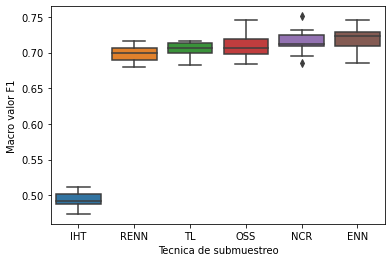

In [13]:
sns.boxplot(x="variable", y="value", data=pd.melt(results))
if not os.path.exists('figures/modeling_basic'):
    os.makedirs('figures/modeling_basic')
plt.ylabel('Macro valor F1')
plt.xlabel('Tecnica de submuestreo')
plt.savefig('figures/modeling_basic/mb_subsample.png', bbox_inches='tight', dpi=300, transparent=True)

In [45]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = RandomForestClassifier()
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('s', models[i]), ('m',model)])
    # evaluate the model and store results
    print(models[i])
    evaluate_model(X_train, y_train, pipeline, f1_macro)

TomekLinks()
min: 0.6812854191050038
max: 0.7293561923308759
mean: 0.7081888635843062
EditedNearestNeighbours()
min: 0.7000215265739891
max: 0.7437260988424574
mean: 0.7249927388509014
RepeatedEditedNearestNeighbours()
min: 0.6913181622602478
max: 0.7152153336488405
mean: 0.7038746760261354
OneSidedSelection()
min: 0.6766241594167114
max: 0.7346257206514
mean: 0.7071219612210558
NeighbourhoodCleaningRule()
min: 0.684745794768136
max: 0.7470828359460056
mean: 0.7199188261331855
InstanceHardnessThreshold()
min: 0.472813758834455
max: 0.4938446193816107
mean: 0.4856295232665266


In [38]:
model = XGBClassifier(use_label_encoder=False)
# scale, then undersample, then fit model
pipeline = Pipeline(steps=[('nr',norm), ('s', models[1]), ('m',model)])
pipeline.fit(X_train, y_train)

[04:28:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('nr', Normalizer()), ('s', EditedNearestNeighbours()),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               vali

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2683
           1       0.58      0.55      0.56       326

    accuracy                           0.91      3009
   macro avg       0.76      0.75      0.75      3009
weighted avg       0.91      0.91      0.91      3009



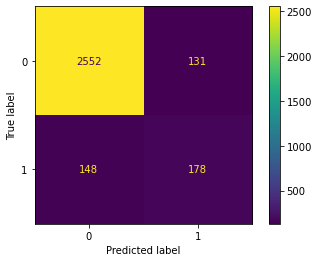

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)